# Calculate the seasonal means of errors in MDM and QDM+ sort predictions
- MDM: Moment Delta Mapping
- Consider the MDM operators L_1 and L_2 which map the mean and mean and stdev of a distribution respectively
- MDM error for operator L_i  = [L_i (Q_historical) ] - Q_future
- In this notebook, Q_historical is the pre-industrial quantile function and Q_future is the End of 21st century quantile function
- These quantile functions are constructed from detrended CESM2 LENS data
- We can similarly caluclate errors for the Gaussian operators G1 and G2 (see paper for more details)
- In this notebook, we compute the seasonal mean of the MDM error for various operators

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
#import xskillscore as xs
import cartopy as cart
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.special import erfinv, erf
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [3]:
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_shift(ds_obs,init_mean,final_mean):
    # Assuming coordinates year and day for ds_obs
    obs_mean   = ds_obs.mean('year')
    ds_shift   = obs_mean + (final_mean - init_mean) + ds_obs - obs_mean        
    return ds_shift

def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

In [4]:
def gauss_quantile(mean,std,quantile):
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue

In [5]:
def select_months(data, months):
    """
    Selects data for specific months from an xarray DataArray based on dayofyear and year coordinates.

    Parameters:
    data (xarray.DataArray): The input DataArray with 'dayofyear' and 'year' coordinates.
    months (list of int): List of three months to select (e.g., [12, 1, 2] for DJF).

    Returns:
    xarray.DataArray: Filtered DataArray for the specified months.
    """
    # Define the day ranges for each month assuming a 365-day calendar
    month_ranges = {
        1: (1, 31),   # January
        2: (32, 59),  # February
        3: (60, 90),  # March
        4: (91, 120), # April
        5: (121, 151),# May
        6: (152, 181),# June
        7: (182, 212),# July
        8: (213, 243),# August
        9: (244, 273),# September
        10: (274, 304),# October
        11: (305, 334),# November
        12: (335, 365)# December
    }

    # Get the start and end day of the year for each selected month
    days_to_select = []
    for month in months:
        start_day, end_day = month_ranges[month]
        days_to_select.extend(range(start_day, end_day + 1))

    # Filter the data for the specified days of the year
    filtered_data = data.where(data['dayofyear'].isin(days_to_select), drop=True)

    return filtered_data

In [6]:
def altspace(start, step, count, endpoint=False, **kwargs):
   stop = start+(step*count)
   return np.linspace(start, stop, count, endpoint=endpoint, **kwargs)

In [7]:
# #Chicago
LAT        = 41.8781
LON        = (360-87.6298)%360
# # #Bengaluru:
# LAT        = 12.9716
# LON        = 77.5946
######################
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
savefigs   = '/global/scratch/users/harsha/savefigs/Feb21/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
cvals_det  = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
loc        = 'Chicago/'
locn       = 'Chicago'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
###########
print('(lat,lon)=',LAT,LON)

(lat,lon)= 41.8781 272.3702


In [8]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=condo_cumulus_lr6','--account=lr_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=20, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(3)

In [9]:
cluster

Dashboard: http://10.0.39.5:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.39.5:45793,Workers: 0
Dashboard: http://10.0.39.5:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [10]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
pi_year  = 1865
# eoc_year = 2085 #Central year used for detrending
ic_year  = 2086 #This is the correct year for the rolling window operation to work
doy      = 211 # day_of_year
## Change/Check these parameters before running

### Load detrended data

In [11]:
%%time
pi_det   = xr.open_zarr(cvals_det+'pi_detrended.zarr').detrended_tmax
eoc_det  = xr.open_zarr(cvals_det+'eoc_detrended.zarr').detrended_tmax
#
# pi_det   = pi_det.chunk({'member':100,'lat':8,'lon':10,'year':30,'dayofyear':35})
# eoc_det  = eoc_det.chunk({'member':100,'lat':8,'lon':10,'year':30,'dayofyear':35})

CPU times: user 2.14 s, sys: 551 ms, total: 2.69 s
Wall time: 3.16 s


<xarray.DataArray 'detrended_tmax' (lat: 192, lon: 288, member: 100, year: 30,
                                    dayofyear: 365)>
dask.array<open_dataset-5fb251677075321de8a48b5d992e505edetrended_tmax, shape=(192, 288, 100, 30, 365), dtype=float64, chunksize=(8, 60, 100, 10, 73), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 220 221 222 223 224 225 ... 142 143 144 145 146
    degree     int64 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879

### Apply MDM, compute quantile funtions and save data

In [12]:
# Compute mean and std over year i.e, annual mean and stds 
pi_amean  = pi_det.mean('year')
eoc_amean = eoc_det.mean('year')
pi_astd   = pi_det.std('year')
eoc_astd  = eoc_det.std('year')

In [13]:
pi_mdm = implement_mdm(pi_det,pi_amean,eoc_amean,pi_astd,eoc_astd)

In [14]:
pi_shift = implement_shift(pi_det,pi_amean,eoc_amean)

In [15]:
%%time
# pi_mdm.to_dataset().to_zarr(cvals_det+'pi_mdm_intra_simu'+'_'+ic_year0+'_'+ic_year1+'.zarr',mode='w')

CPU times: user 12 µs, sys: 1 µs, total: 13 µs
Wall time: 26.9 µs


In [16]:
%%time
pi_mdm = xr.open_zarr(cvals_det+'pi_mdm_intra_simu'+'_'+ic_year0+'_'+ic_year1+'.zarr').detrended_tmax
pi_mdm

CPU times: user 139 ms, sys: 130 ms, total: 270 ms
Wall time: 322 ms


<xarray.DataArray 'detrended_tmax' (lat: 192, lon: 288, member: 100,
                                    dayofyear: 365, year: 30)>
dask.array<open_dataset-02b7abb9e2d4b6e73cbb25f6d0b85fe3detrended_tmax, shape=(192, 288, 100, 365, 30), dtype=float64, chunksize=(8, 60, 100, 73, 10), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 220 221 222 223 224 225 ... 142 143 144 145 146
    degree     int64 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879

In [17]:
# %%time
# pi_mdm.sel(lat=LAT,lon=LON,method='nearest').sel(member=0,dayofyear=1).values

### Compute quantiles and errors for each season

#### Pick season and months #######

In [18]:
#DJF 
months         = [12,1,2]
season         = 'djf'
#
# #MAM
# months         = [3,4,5]
# season         =  'mam'
#
# #JJA
# months         = [6,7,8]
# season         =  'jja'
#
# #SON
# months         = [9,10,11]
# season         =  'son'

In [19]:
pi_mdm_season   = select_months(pi_mdm,months)
pi_season       = select_months(pi_det,months)
eoc_season      = select_months(eoc_det,months)
#
# Compute mean and std over year i.e, annual mean and stds 
pi_amean_season  = select_months(pi_amean,months)
eoc_amean_season = select_months(eoc_amean,months)
pi_astd_season   = select_months(pi_astd,months)
eoc_astd_season  = select_months(eoc_astd,months)
#
pi_shift_season = implement_shift(pi_season,pi_amean_season,eoc_amean_season)

<xarray.DataArray 'detrended_tmax' (lat: 192, lon: 288, member: 100,
                                    dayofyear: 90, year: 30)>
dask.array<sub, shape=(192, 288, 100, 90, 30), dtype=float64, chunksize=(8, 60, 100, 59, 10), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    degree     int64 1
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879

In [20]:
%%time
qpi_mdm_season   = compute_quantiles(pi_mdm_season)
qpi_shift_season = compute_quantiles(pi_shift_season)
qeoc_season      = compute_quantiles(eoc_season)
qpi_season       = compute_quantiles(pi_season)

CPU times: user 288 ms, sys: 9.21 ms, total: 297 ms
Wall time: 300 ms


In [21]:
%%time
qmdm_err_season   = qpi_mdm_season   - qeoc_season
qshift_err_season = qpi_shift_season - qeoc_season
qshift_err_season

CPU times: user 50.6 ms, sys: 3.97 ms, total: 54.5 ms
Wall time: 51 ms


<xarray.DataArray 'detrended_tmax' (quantile: 30, lat: 192, lon: 288,
                                    member: 100, dayofyear: 90)>
dask.array<sub, shape=(30, 192, 288, 100, 90), dtype=float64, chunksize=(30, 8, 60, 100, 59), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [23]:
# %%time
# qmdm_err_season.to_dataset().to_zarr(cvals_det+'mdm_err_'+season+'_'+ic_year0+'_'+ic_year1+'.zarr',mode='w')

In [24]:
# %%time
# qshift_err_season.to_dataset().to_zarr(cvals_det+'shift_err_'+season+'_'+ic_year0+'_'+ic_year1+'.zarr',mode='w')

In [25]:
## Open files
qmdm_err_season   = xr.open_zarr(cvals_det+'mdm_err_'+season+'_'+ic_year0+'_'+ic_year1+'.zarr').detrended_tmax
qshift_err_season = xr.open_zarr(cvals_det+'shift_err_'+season+'_'+ic_year0+'_'+ic_year1+'.zarr').detrended_tmax

In [26]:
qshift_err_season.sel(lat=LAT,lon=LON,method='nearest').sel(member=0,dayofyear=1).values

array([-0.1569876 , -3.31926574, -2.16855256, -2.48411336, -2.27708265,
       -2.11104308, -2.0324448 , -0.49720414,  0.54725344,  0.40675286,
        0.0424645 , -0.01903917,  0.30523343,  0.05658645,  0.83924732,
        0.7469418 ,  1.05163709,  1.37501874,  1.73546909,  1.79730838,
        1.66014981,  1.68538488,  0.78133684,  0.94610006,  1.31502228,
       -0.07461113,  0.10874451, -0.18356484,  1.11495102, -1.1916934 ])

### Compute Gaussian quantile functions and errors

In [27]:
# Create a DataArray for the quantiles
quantiles = xr.DataArray(np.linspace(0,1.0,30), dims='quantile').assign_coords(quantile=('quantile',quants))

In [28]:
####### Construct gaussians for EOC ################
qgauss_standard_normal        = xr.apply_ufunc(erfinv,2*quantiles-1)
#################
qpi_gauss_season      = eoc_amean_season + eoc_astd_season * np.sqrt(2) *qgauss_standard_normal
qpi_gauss_season.name = 'qgauss_detrended'
qpi_gauss_season
## gaussmo = gaussian with eoc mean only and pre-ind std
qpi_gaussmo_season      = eoc_amean_season + pi_astd_season * np.sqrt(2) * qgauss_standard_normal      
qpi_gaussmo_season.name = 'qgaussmo_detrended'
qpi_gaussmo_season

<xarray.DataArray 'qgaussmo_detrended' (lat: 192, lon: 288, member: 100,
                                        dayofyear: 90, quantile: 30)>
dask.array<add, shape=(192, 288, 100, 90, 30), dtype=float64, chunksize=(8, 60, 100, 59, 30), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    degree     int64 1
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [29]:
%%time
qgauss_err_season   = qpi_gauss_season   - qeoc_season
qgaussmo_err_season = qpi_gaussmo_season - qeoc_season
#
qgauss_err_season.name   = 'qgauss_error'
qgaussmo_err_season.name = 'qgaussmo_error'
#
qgauss_err_season

CPU times: user 62.3 ms, sys: 6.4 ms, total: 68.7 ms
Wall time: 63.2 ms


<xarray.DataArray 'qgauss_error' (lat: 192, lon: 288, member: 100,
                                  dayofyear: 90, quantile: 30)>
dask.array<sub, shape=(192, 288, 100, 90, 30), dtype=float64, chunksize=(8, 60, 100, 59, 30), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    degree     int64 1
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [30]:
# %%time
# qgauss_err_season.to_dataset().to_zarr(cvals_det+'gauss_err_'+season+'_'+ic_year0+'_'+ic_year1+'.zarr',mode='w')
# qgaussmo_err_season.to_dataset().to_zarr(cvals_det+'gaussmo_err_'+season+'_'+ic_year0+'_'+ic_year1+'.zarr',mode='w')

In [31]:
%%time
qgauss_err_season   = xr.open_zarr(cvals_det+'gauss_err_'+season+'_'+ic_year0+'_'+ic_year1+'.zarr').qgauss_error
qgaussmo_err_season = xr.open_zarr(cvals_det+'gaussmo_err_'+season+'_'+ic_year0+'_'+ic_year1+'.zarr').qgaussmo_error

CPU times: user 622 ms, sys: 261 ms, total: 883 ms
Wall time: 943 ms


### Plot MDM errors

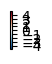

In [32]:
######## New colorbar only for shift + stretch and gaussian ############
x = 5
# create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
# Define colormap
cmap = plt.get_cmap('RdBu_r')
# Make a norm object with the center at 0: TwoSlopeNorm
norm = mcolors.TwoSlopeNorm(vmin=-x, vcenter=0, vmax=x)
# Making numpy array from -3 to 3, with step 0.2
values = np.arange(-x, x+0.25, 0.25)
# Creating a mappable object and setting the norm and cmap for colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
# Creating a colorbar
ticks1 = altspace(-4,1,9)
cbar = plt.colorbar(mappable, ax=ax, orientation='vertical',ticks=ticks1)
cbar.set_label('')
plt.gca().set_visible(False)

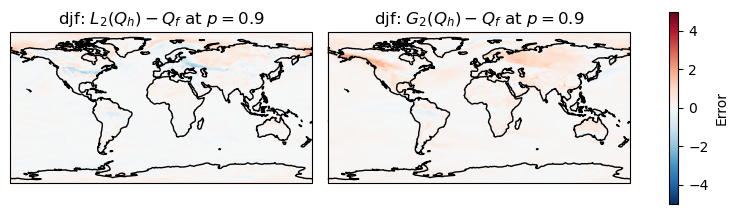

CPU times: user 49.1 s, sys: 3.23 s, total: 52.3 s
Wall time: 1min 4s


In [33]:
%%time
member =0 
# Creating a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), subplot_kw={'projection': cart.crs.PlateCarree()}\
                       , gridspec_kw = {'wspace':0.05, 'hspace':0.2})

# Plotting qgmsc_err
qmdm_err_season.sel(quantile=0.9,method='nearest').sel(member=member).mean('dayofyear').plot(ax=axs[0], transform=cart.crs.PlateCarree(),\
                                                    add_colorbar=False, cmap=cmap, norm=norm)
axs[0].coastlines(color="black")
axs[0].set_title(season+r': $L_2(Q_h) - Q_f$ at $p=0.9$')

# Plotting G2, gaussian error
im = qgauss_err_season.sel(quantile=0.9,method='nearest').sel(member=member).mean('dayofyear').plot(ax=axs[1], transform=cart.crs.PlateCarree(),\
                                                          add_colorbar=False, cmap=cmap, norm=norm)
axs[1].coastlines(color="black")
axs[1].set_title(season+': $G_2(Q_h) - Q_f$ at $p=0.9$')

# Adding colorbar
cbar = plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5, orientation='vertical')
cbar.set_label('Error')

plt.show()

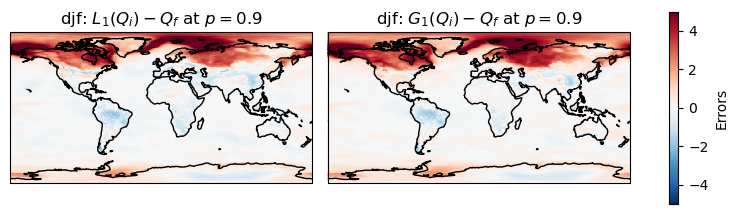

CPU times: user 46.9 s, sys: 3.07 s, total: 50 s
Wall time: 1min


In [34]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), subplot_kw={'projection': cart.crs.PlateCarree()}\
                       , gridspec_kw = {'wspace':0.05, 'hspace':0.2})

# Plotting qgmsc_err
qshift_err_season.sel(quantile=0.9,method='nearest').sel(member=member).mean('dayofyear').plot(ax=axs[0], transform=cart.crs.PlateCarree(),\
                                                    add_colorbar=False, cmap=cmap, norm=norm)
axs[0].coastlines(color="black")
axs[0].set_title(season+': $L_1(Q_i) - Q_f$ at $p=0.9$')

# Plotting da2
im = qgaussmo_err_season.sel(quantile=0.9,method='nearest').sel(member=member).mean('dayofyear').plot(ax=axs[1], transform=cart.crs.PlateCarree(),\
                                                          add_colorbar=False, cmap=cmap, norm=norm)
axs[1].coastlines(color="black")
axs[1].set_title(season+r': $G_1(Q_i) - Q_f$ at $p=0.9$')

# Adding colorbar
cbar = plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5, orientation='vertical')
cbar.set_label('Errors')

plt.show()

### Compute ensemble mean of absolute errors

In [ ]:
qmdm_abserr_season = np.abs(qmdm_err_season)


In [ ]:
#############################################################################################################